In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

#pymc and visualisation
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
from pytensor.compile.ops import as_op

#Dataset and models
from libraries.dataset import *
from libraries.cancer_models import *

In [ ]:
dt = 0.1
eps = 10**-2
print(patients)

#put the datasets into pandas'dataframes for pymc
data = pd.DataFrame(columns=['patient', 'time', 'mtm'])

k = 0
for patient in patients:
  for j in range(len(time_dataset[patient])):
    time = time_dataset[patient][j] -time_dataset[patient][0]
    y_obs = mtm_dataset[patient][j]
    data.loc[k] = [patient] + list([time, y_obs])
    k += 1

drug_times_data = pd.DataFrame(columns=['patient', 'drug_times'])
k = 0
for patient in patients:
  for j in range(len(time_drug_dataset[patient])):
    time = time_drug_dataset[patient][j] - time_dataset[patient][0]
    drug_times_data.loc[k] = [patient] + list([time])
    k += 1

In [3]:
patient_index, patients_list = data.patient.factorize()
coords = {"patient": patients_list}

## FS-EXP

In [4]:
@as_op(itypes=[pt.dvector,pt.dvector,pt.dvector], otypes=[pt.dvector])  #flag for pytensor
def model_output_concatenated(S_0, delta_0 , C):
    dt = 0.4     #to speed-up we set dt=0.4, as it gives the same results
    Y_all = []   #list to concatenate all the patients' prediction

    i = 0
    for p in patients:
      y_obs = mtm_dataset[p]
      times = np.array(time_dataset[p])
      drug_times = np.array(time_drug_dataset[p])  - times[0]
      times = times - times[0]

      params = np.array([S_0[i], delta_0[i], C[i]])
      y = np.array(model_wrapper("fs_exp", params, y_obs, times, drug_times, dt=dt)) #model output given parameters
      y = y[np.array(times/dt).astype(int)]

      for l in range(len(y)):
        Y_all.append(np.log(y[l]+eps))

      i += 1
    return np.array(Y_all)

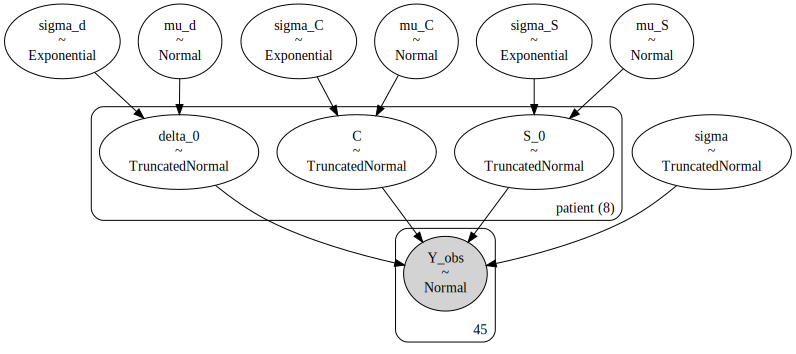

In [5]:
y_obs_0 = data.loc[data["time"] == 0] #get first measurment for all the patients

with pm.Model(coords=coords) as hierarchical_fs:
  y_obs_all = data["mtm"].to_numpy()
  y_obs_all_log = np.log(y_obs_all + eps)

  #set hyperparameters priors
  mu_S = pm.Normal("mu_S", mu=0.98, sigma = 0.01)
  sigma_S = pm.Exponential("sigma_S", 1/0.05)
  mu_d = pm.Normal("mu_d", mu=2, sigma = 0.5)
  sigma_d = pm.Exponential("sigma_d", 1/0.5)
  mu_C = pm.Normal("mu_C", mu=10, sigma = 1)
  sigma_C = pm.Exponential("sigma_C", 1/2)

  #set parameters priors
  S_0 = pm.TruncatedNormal("S_0", mu=mu_S, sigma=sigma_S, lower=0.85, upper=1., dims="patient")
  delta_0 = pm.TruncatedNormal("delta_0", mu=mu_d, sigma=sigma_d, lower=1, upper=5, dims="patient")
  C = pm.TruncatedNormal("C", mu=mu_C, sigma=sigma_C, lower=1, upper=55, dims="patient")

  #set pooled parameters priors
  sigma = pm.TruncatedNormal("sigma",mu=0.65, sigma=0.5, lower=0.01, upper=2.5)


  y_hat = model_output_concatenated(S_0, delta_0 , C)
  pm.Normal("Y_obs", mu=y_hat, sigma=sigma, observed=y_obs_all_log)

pm.model_to_graphviz(model=hierarchical_fs)

In [ ]:
#run NUTS and save to file
with hierarchical_fs:
  trace = pm.sample(draws=14000, tune=1000, chains=2, cores=4)
  trace.to_netcdf('hierachical_models_fs_exp.nc')

<ipython-input-4-fdb4d0153e85>:17: RuntimeWarning: invalid value encountered in log
  Y_all.append(np.log(y[l]+eps))
<ipython-input-4-fdb4d0153e85>:17: RuntimeWarning: invalid value encountered in log
  Y_all.append(np.log(y[l]+eps))


In [6]:
#if already run the algorithm load from file (uncomment the line below):
trace = az.from_netcdf("hierachical_models_fs_exp.nc")

In [8]:
#summary statistics for the loaded draws
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_S,0.983,0.008,0.968,1.001,0.000,0.000,714.0,983.0,1.00
mu_d,2.410,0.403,1.601,3.105,0.033,0.024,137.0,521.0,1.03
mu_C,9.006,0.984,7.278,10.921,0.025,0.018,1509.0,5449.0,1.00
sigma_S,0.023,0.023,0.001,0.059,0.001,0.001,213.0,201.0,1.01
sigma_d,0.522,0.385,0.031,1.228,0.026,0.019,145.0,195.0,1.01
sigma_C,5.453,1.781,2.487,8.765,0.054,0.038,976.0,2689.0,1.00
S_0[C233],0.968,0.022,0.929,1.000,0.001,0.001,336.0,392.0,1.01
S_0[C035],0.984,0.013,0.963,0.999,0.000,0.000,593.0,1343.0,1.00
S_0[C095],0.973,0.019,0.939,0.998,0.001,0.001,451.0,671.0,1.01
S_0[C160],0.971,0.018,0.937,0.996,0.001,0.001,570.0,1187.0,1.00


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


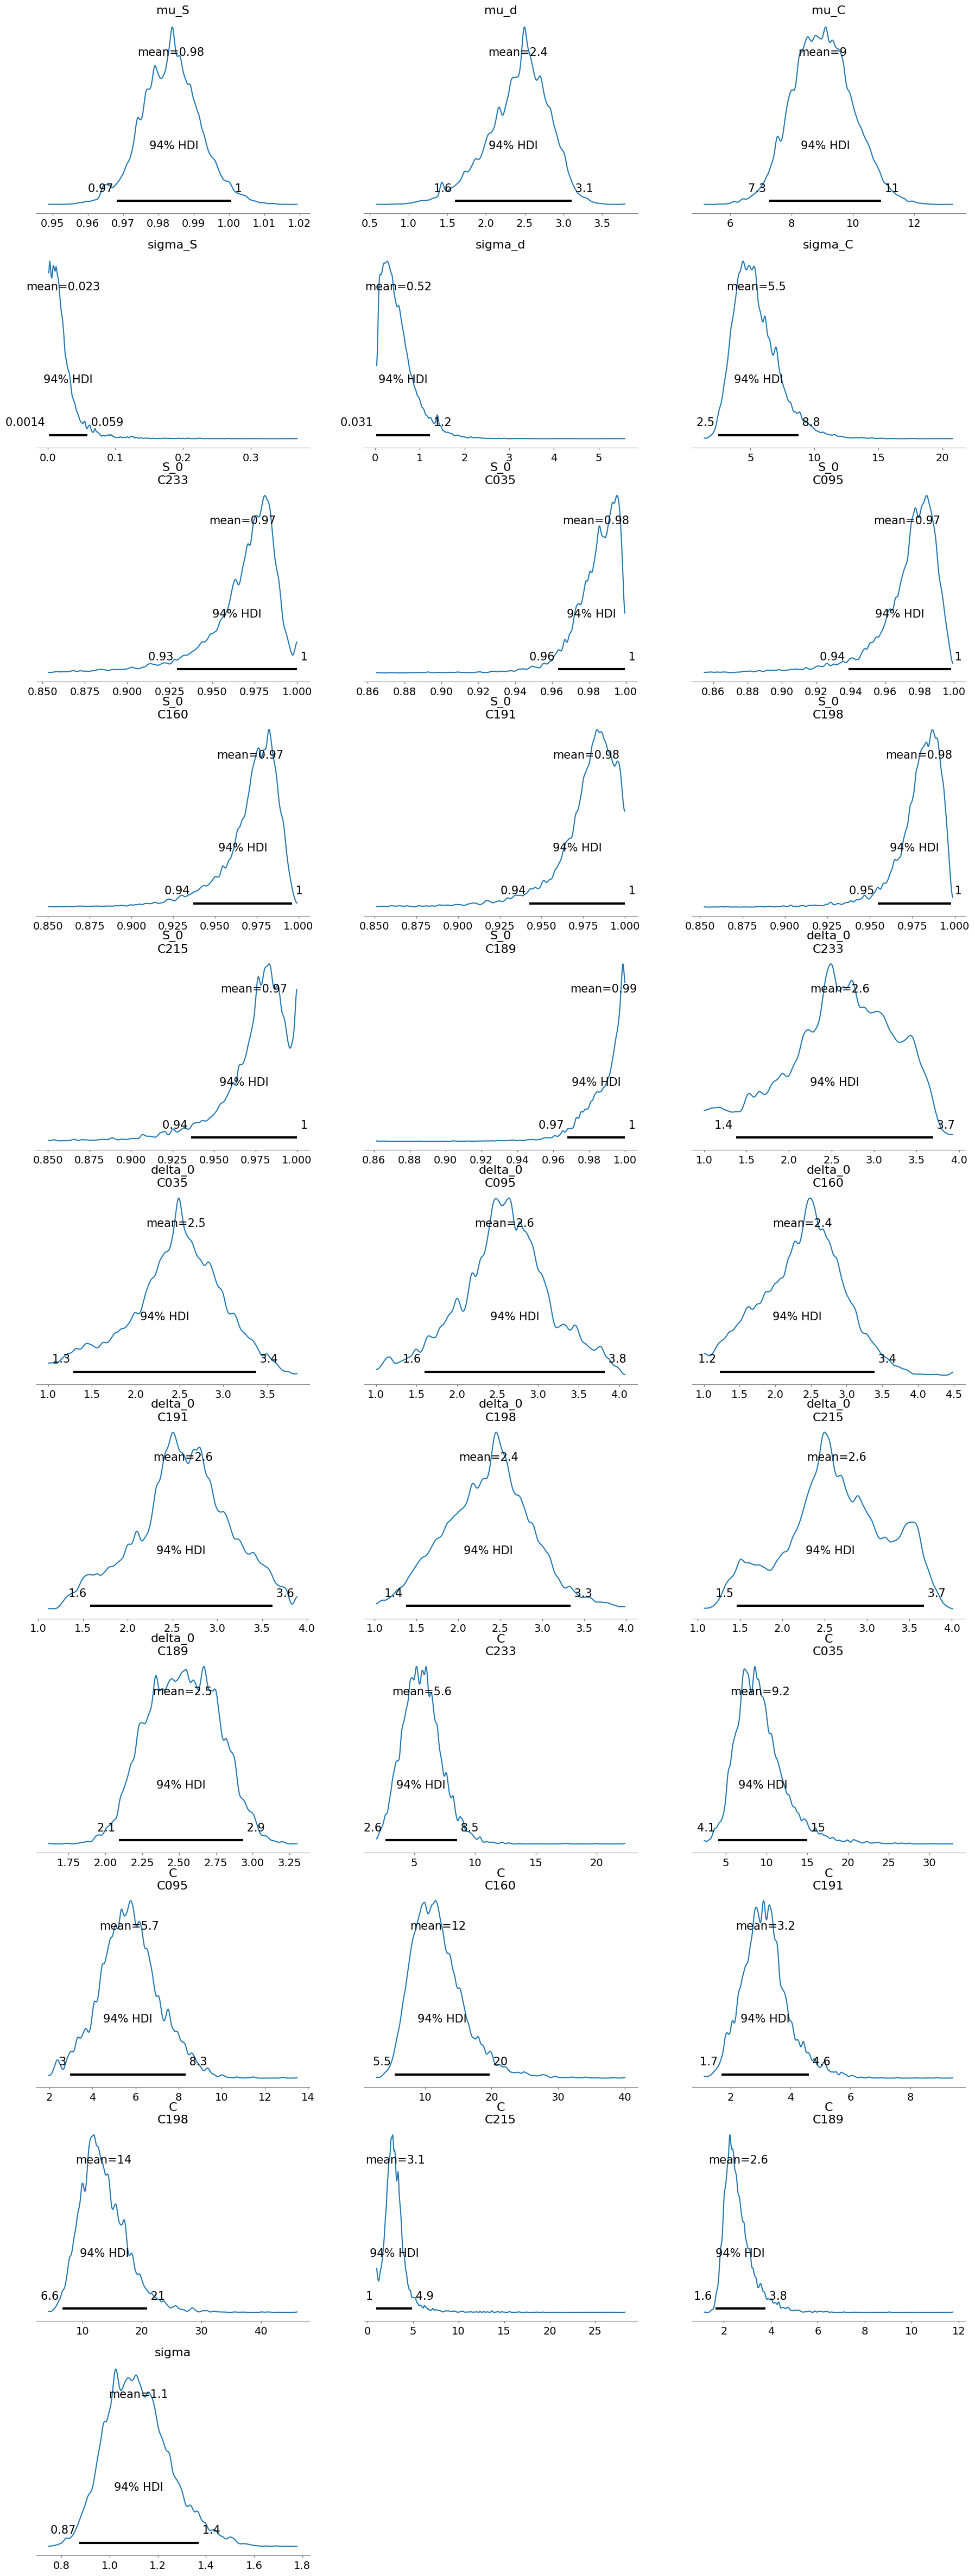

In [14]:
#visualise the posteriors
pm.plot_posterior(trace, grid=(11,3));

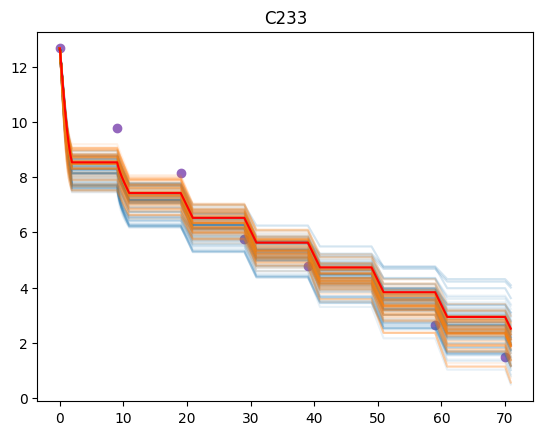

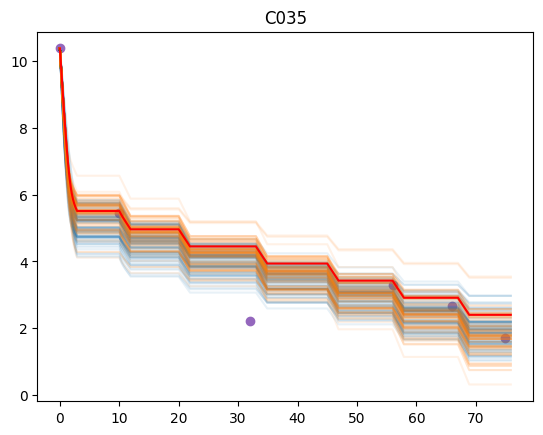

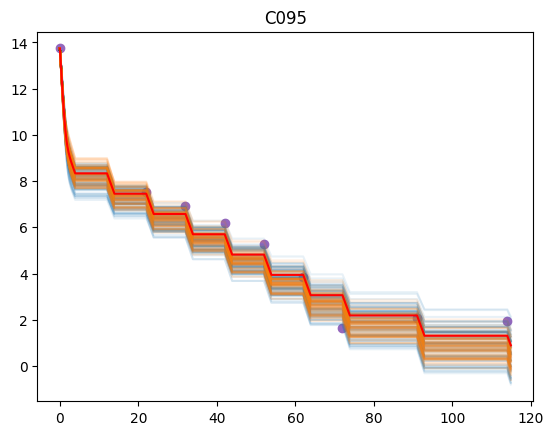

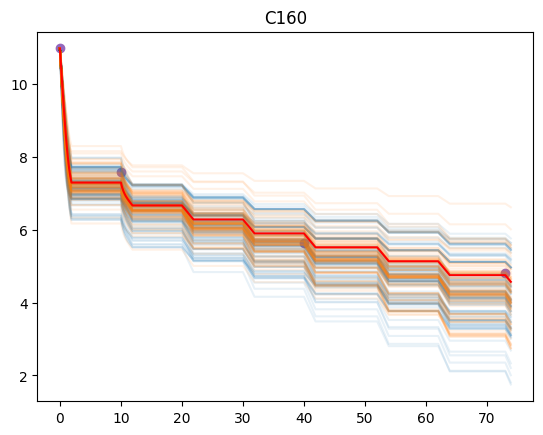

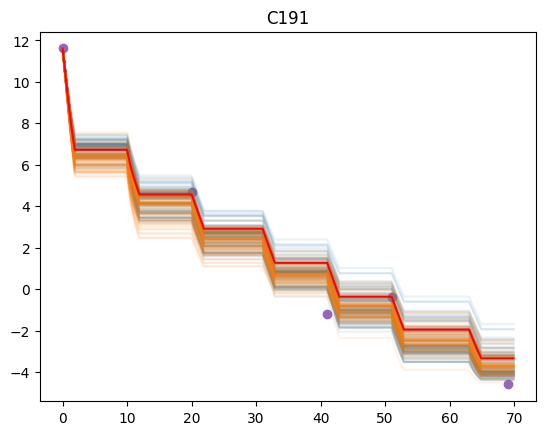

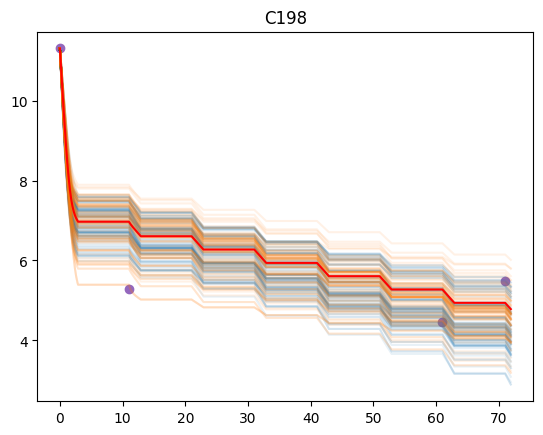

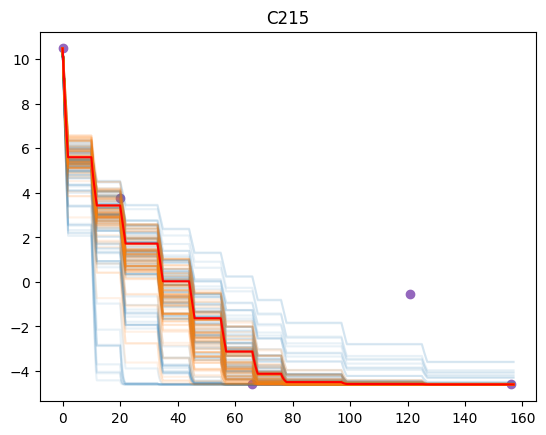

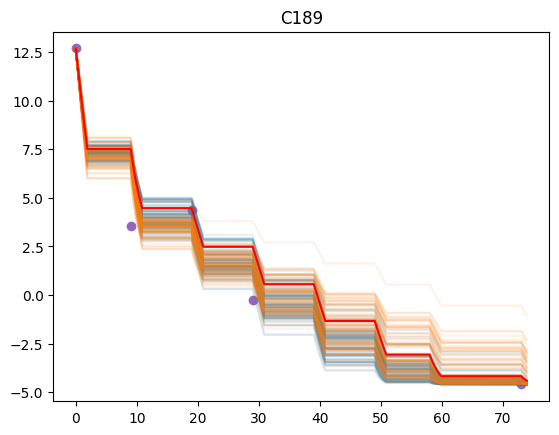

In [15]:
nChains = 2
nDraws = 14000
nToPlot = 100

#plot some dynamics for each patient
for patient_id in patients:
  y_obs = np.array(data[data["patient"] == patient_id]["mtm"])
  times = np.array(data[data["patient"] == patient_id]["time"])
  drug_times = np.array(drug_times_data[drug_times_data["patient"] == patient_id]["drug_times"])
  I = np.arange(0,times[-1]+1,0.1)


  #plot the dynamic for the last <nToPlot> parameters draws (either in blue or orange depending on which chain)
  for chain in range(0,nChains):
    for draw in range(nDraws-nToPlot,nDraws):
      means = trace["posterior"].sel(chain=chain,patient=patient_id, draw=draw).mean() #get the parameters of a specific draw (mean is to get the actual value)

      params = np.array([means['S_0'], means['delta_0'], means['C']])

      y = np.array(model_wrapper("fs_exp", params, y_obs, times, drug_times))
      plt.plot(I, np.log(y+eps),alpha=0.1,color=f"C{chain}")

  #plot the dynamic for the mean parameters over all the draws (in red)
  drug_times = np.array(drug_times_data[drug_times_data["patient"] == patient_id]["drug_times"])
  means = trace["posterior"].sel(patient=patient_id).mean() #get the parameters' mean
  params = np.array([means['S_0'], means['delta_0'], means['C']])
  y = np.array(model_wrapper("fs_exp", params, y_obs, times, drug_times))
  plt.plot(I, np.log(y+eps),color=f"r")

  #plot the real data (purple dots)
  plt.scatter(times, np.log(y_obs+eps),color="C4")
  plt.title(patient_id)
  plt.show()

We used the mean of the posteriors as the estimators of the parameters.<br>
Also compute the AIC and the $R^2$ to compare with the unpooled optimisation.

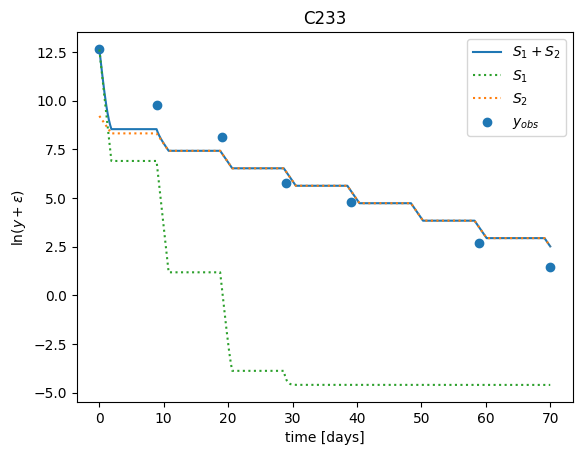

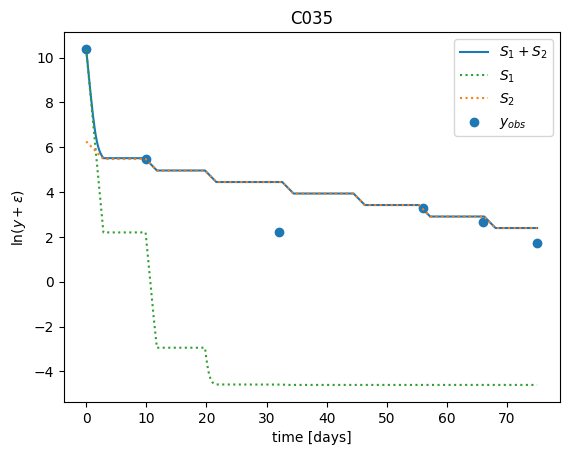

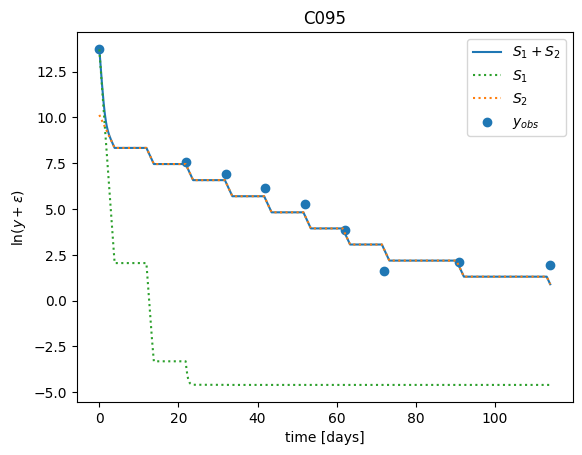

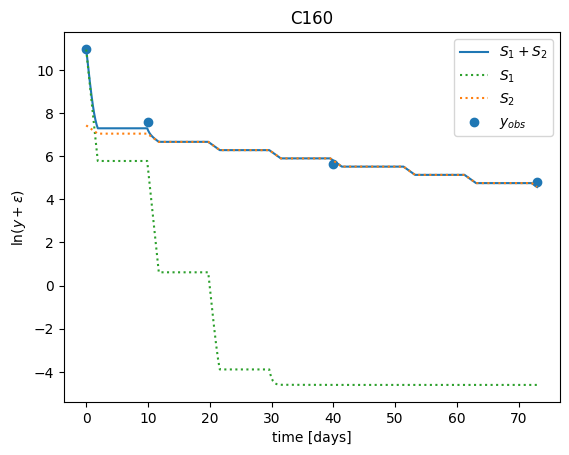

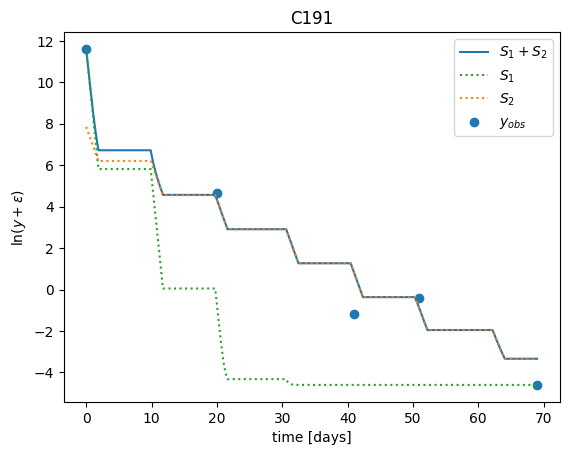

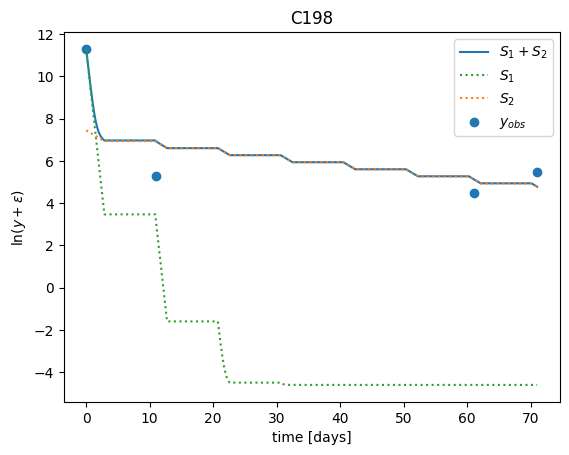

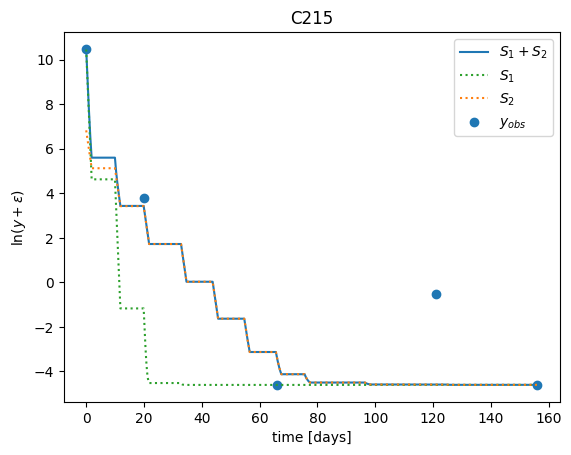

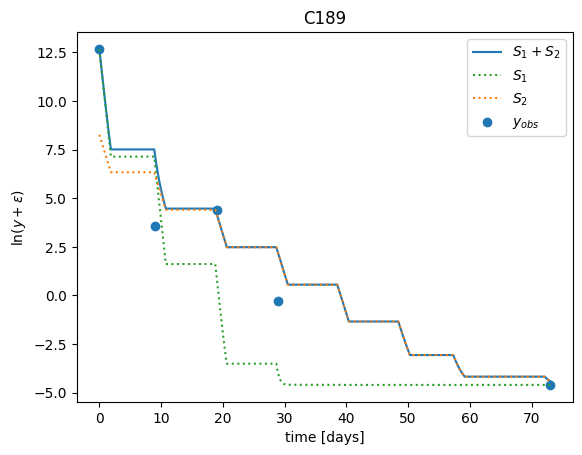

AIC:179.6832526856163
R^2:0.8567900546156986


In [10]:
AIC_tot = 0

y_pred_all = []
y_obs_all = []

for patient_id in patients:
  #load patient's data
  y_obs = np.array(data[data["patient"] == patient_id]["mtm"])
  times = np.array(data[data["patient"] == patient_id]["time"])
  drug_times = np.array(drug_times_data[drug_times_data["patient"] == patient_id]["drug_times"])
  I = np.arange(0,times[-1]+1,0.1)

  #get the estimated parameters by taking the mean of the posteriors:
  drug_times = np.array(drug_times_data[drug_times_data["patient"] == patient_id]["drug_times"])
  means = trace["posterior"].sel(patient=patient_id).mean()
  params = np.array([means['S_0'], means['delta_0'], means['C']])

  #compute predicted dynamic and plot (with the individual sub-populations)
  y_pred,s_pred,r_pred= model_fs_exp(params, y_obs, times[-1], drug_times, parts=True)
  plt.plot(np.linspace(0,times[-1],len(y_pred)),np.log(y_pred+eps), color="C0", label=r"$S_1+ S_2$")
  plt.plot(np.linspace(0,times[-1],len(y_pred)),np.log(s_pred+eps), linestyle=":", color="C2", alpha=1, label=r"$S_1$")
  plt.plot(np.linspace(0,times[-1],len(y_pred)),np.log(r_pred+eps), linestyle=":", color="C1", alpha=1, label=r"$S_2$")
  plt.xlabel("time [days]")
  plt.ylabel(r"$\ln(y+\varepsilon)$")
  plt.title(f"{patient_id}")

  #real data:
  plt.scatter(times,np.log(y_obs+eps), label=r"$y_{obs}$")
  plt.legend()
  plt.show()

  #also get the mean sigma and then compute the log-likelihood to obtain the total AIC score
  all_params = np.array([means['sigma'], means['S_0'], means['delta_0'], means['C']])
  l = objective_wrapper(all_params,'fs_exp', times, y_obs, drug_times)

  #AIC
  AIC_tot += 2*l+ 2*3 #FS's number of parameters is 3


  #for the R^2
  mask = np.array(times/dt).astype(int)
  start_idx = 1 #if = 0 then it will also take the first predicted point in account when calculating the R^2 (which is identical to y_obs[0]), otherwise put to 1
  y_pred_all = np.hstack((y_pred_all,y_pred[mask][start_idx:]))
  y_obs_all = np.hstack((y_obs_all,y_obs[start_idx:]))


print(f"AIC:{AIC_tot}")


#calculate the R^2:
y_obs_all = np.array(y_obs_all)
y_pred_all = np.array(y_pred_all)


SSE = np.sum((np.log(y_obs_all+eps) - np.log(y_pred_all+eps))**2)
SST = np.sum((np.log(y_obs_all+eps) - np.log(y_obs_all+eps).mean())**2)
R_squared = 1 - (SSE/SST)

print(f"R^2:{R_squared}")


/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (31), generating only 20 plots
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


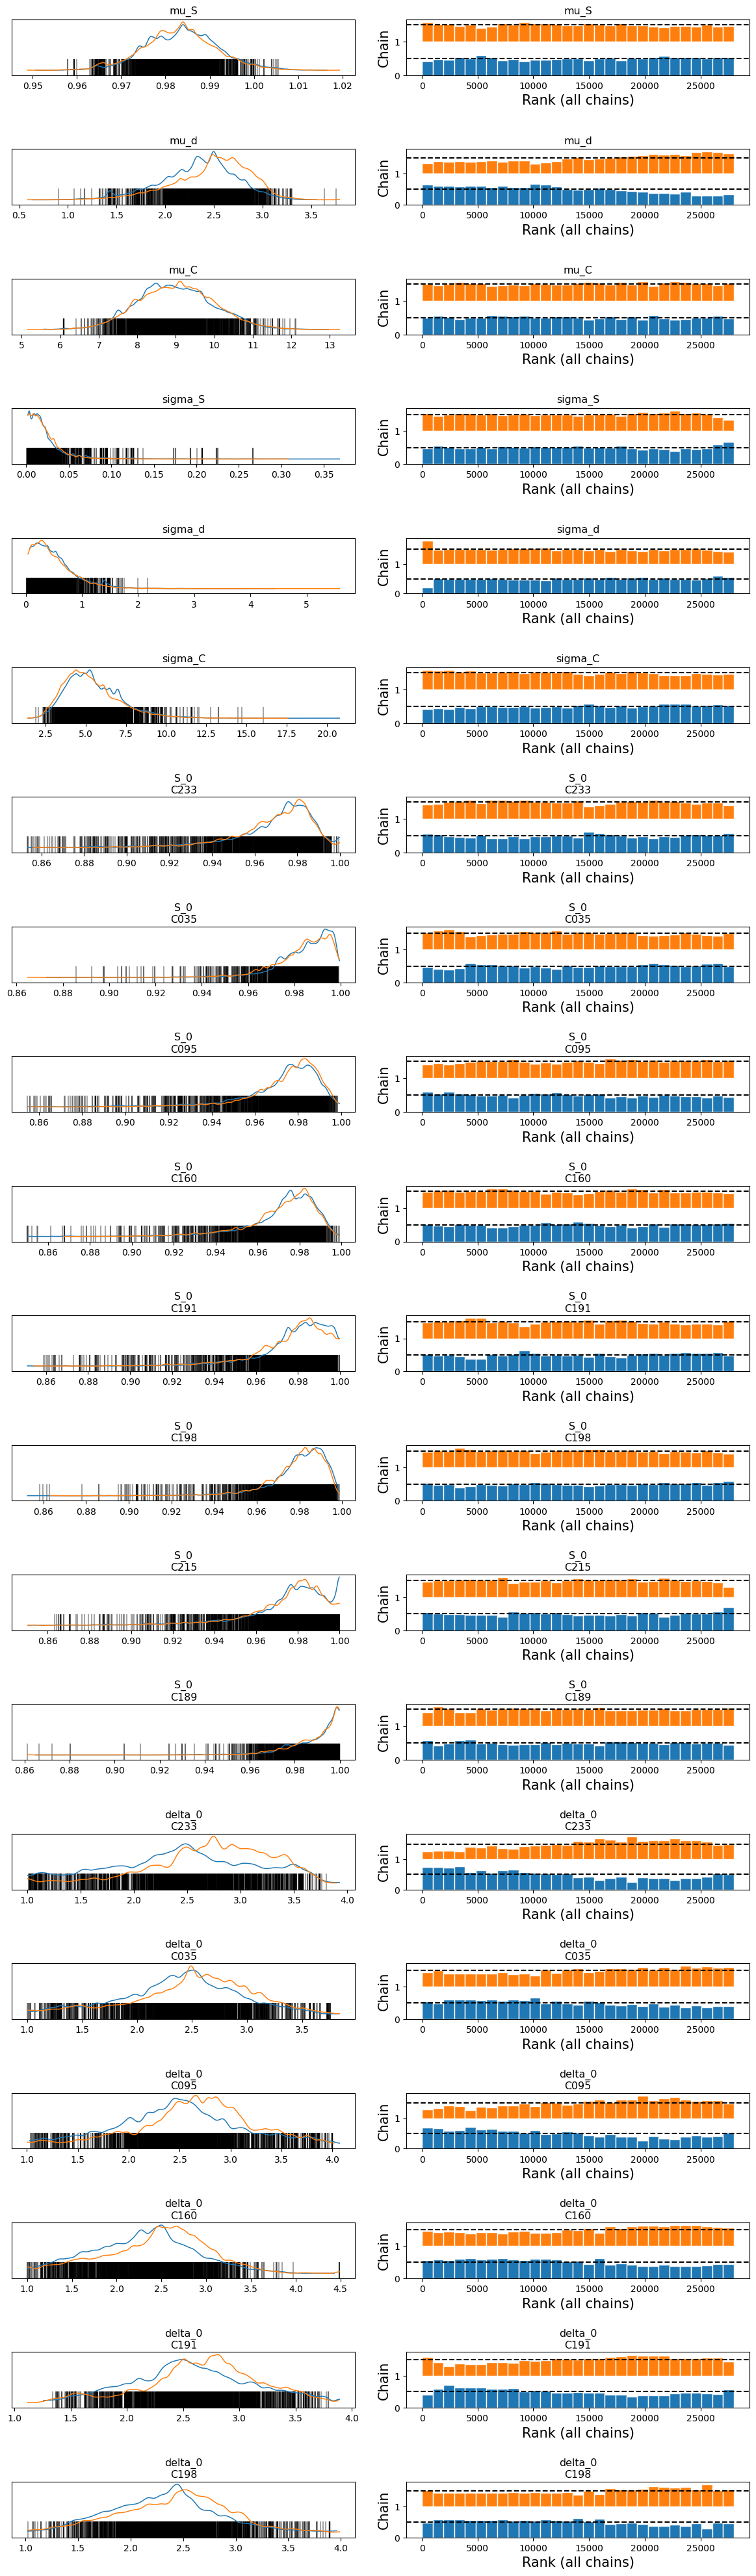

In [11]:
az.plot_trace(trace, kind="rank_bars", compact=False)
plt.tight_layout(pad=2.0)